In [21]:
import csv
import numpy as np
import utils
import hrr_utils
import time


from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

N=1000

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2


def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present,rcond=5e-2), Past)

# HD Algo
def train(W, past, present):
    # col x row
    W += np.outer(present, past)
    return W

def reg_train(W, Past, Present):
    pred = np.dot(W, Present)
    W += ((N*N-sim(pred, Past))/float(N*N)) * np.outer(Past, Present)
    return W

def train_diff(W, past2, present1, present2):
    W += np.outer(present1, past2-present2)
    return W

def reg_train_diff(W, past2, present1, present2):
    W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    pred = np.dot(W, present1) + present2*N
    W += ((N*N-sim(pred, past2))/float(N*N)) * np.outer(present1, past2-present2)
    return W

def total_vec(W):
    return np.diag(W)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def graph(x, y1, y2, title=None, xlabel='number of words', ylabel='average dot product', legend='upper right'):

    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc=legend)
    plt.show()
    #fig.savefig('test.jpg')
    
def graphwstd(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product', legend='upper right'):
    """
    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc=legend)
    plt.show()
    #fig.savefig('test.jpg')
    """
    
    fig = plt.figure(figsize=(4,3))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend)

    plt.xlabel('Number Training Examples')
    plt.ylabel('Feature Similarity')
    plt.title(title)

    plt.xlim([0, 1700])

    plt.tight_layout()

In [45]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)

data_size = 300
reg_pres, reg_past, reg_freq = reg_pres[:data_size], reg_past[:data_size], reg_freq[:data_size]
irreg_pres, irreg_past, irreg_freq = irreg_pres[:data_size], irreg_past[:data_size], irreg_freq[:data_size]

regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

#train_cutoff = 1700
train_cutoff = 250

train_reg = regular[0:train_cutoff]
train_irreg = irregular[0:train_cutoff]


test_reg = regular[train_cutoff:]
test_irreg = irregular[train_cutoff:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

regular.extend(irregular)
verbs = regular

In [46]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

(1000.0, -0.95999999999999996)
(996.0, -1.9199999999999999)
(1008.0, -2.8799999999999999)
(982.0, -3.8399999999999999)
(962.0, -4.7999999999999998)
(978.0, -5.7599999999999998)
(1010.0, -6.719999999999998)
(966.0, -7.6799999999999997)
(1000.0000000000002, -8.6400000000000041)


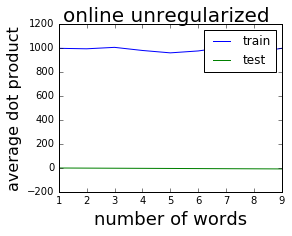

figures/online-unregularized_trigam_regression-N=1000-W=439-170416


In [91]:
w = np.zeros(N)
x = np.arange(1, 10, 1)#trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    # W = closed_train(trainpast2[0].reshape((N,1)).T, trainpres1[0].reshape((N,1)).T)
    W = closed_train(trainpast2[0].reshape((1,N)), trainpres1[0].reshape((1,N)))
    #print W.shape
    w += total_vec(W)
    #print w.shape
    # print W
    # print w

    train_pred = np.multiply(w, trainpres1[:k])*N
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(w, testpres1)*N
    #test_pred = np.where(test_pred>0, 1, -1)
    #print testpast2.shape
    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
    print (y1[i], y2[i])
    
graph(x,y1,y2,title='online unregularized',legend='upper right')

fname =  ('figures/online-unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

# W = closed_train(trainpast2[0].reshape((N,1)).T, trainpres1[0].reshape((N,1)).T)
# # print W.shape
# w += total_vec(W)
# # print W
# # print w

# train_pred = np.multiply(w, trainpres1[0])*N

# #train_pred = np.where(train_pred>0, 1, -1)
# test_pred = np.multiply(w, testpres1)*N
# #test_pred = np.where(test_pred>0, 1, -1)

# sim1 = sim(train_pred.T, trainpast2[0].T).mean()
# sim2 = sim(test_pred.T, testpast2.T).mean()

# print(sim1,sim2)
    

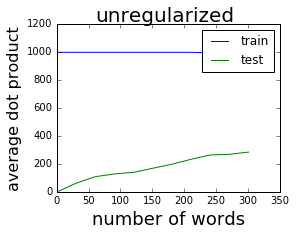

figures/unregularized_trigam_regression-N=1000-W=320-170416


In [12]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 30)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = closed_train(trainpast2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
graph(x,y1,y2,title='unregularized',legend='upper right')

fname =  ('figures/unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


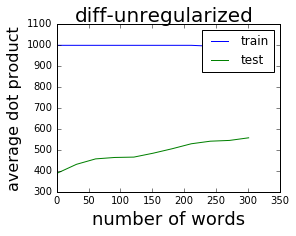

figures/diff_unregularized_trigam_regression-N=1000-W=320-170416


In [13]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 30)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = closed_train(trainpast2[:k]-trainpres2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W) + trainpres2[:k]
    test_pred = testpres1.dot(W) + testpres2

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
graph(x,y1,y2,title='diff-unregularized',legend='upper right')

fname =  ('figures/diff_unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

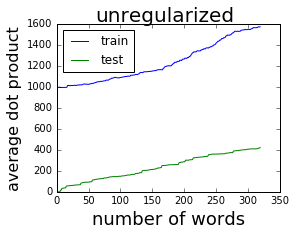

figures/unregularized_outer_trigam_dict-N=1000-W=320-170416


In [14]:
W = np.zeros((N,N))
W = train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
for i in range(x.shape[0]):
    k = x[i]
    train_pred = W.T.dot(trainpres1[:k].T).T
    test_pred = W.T.dot(testpres1.T).T

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()

    W = train(W, trainpast2[k], trainpres1[k])

graph(x,y1/N,y2/N,"unregularized", legend="upper left")

fname =  ('figures/unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

# change location/ add location parameter for legend

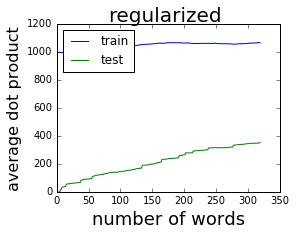

figures/regularized_outer_trigam_dict-N=1000-W=320-170416


In [15]:
W = np.zeros((N,N))
W = reg_train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):
    k = x[i]
    #train_pred = W.T.dot(trainpres1[:k].T).T
    #test_pred = W.T.dot(testpres1.T).T
    
    train_pred = np.dot(W, trainpres1[:k, :].T).T
    test_pred = np.dot(W, testpres1.T).T
    
    y1[i] = sim(train_pred/float(N), trainpast2[:k, :]).mean()
    y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    W = reg_train(W, trainpast2[k], trainpres1[k])
    

graph(x,y1,y2,title='regularized', legend='upper left')

fname =  ('figures/regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

# change location/ add location parameter for legend

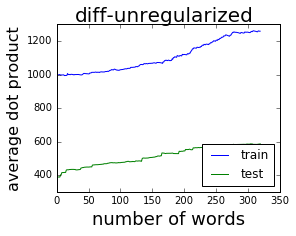

figures/diff_unregularized_outer_trigam_dict-N=1000-W=320-170416


In [16]:
W = np.zeros((N,N))
W = train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + (testpres2*N)
    #train_pred = np.dot(W, trainpres1[:k, :].T).T + trainpres2[:k, :]*N
    #test_pred = np.dot(W, testpres1.T).T + (testpres2*N)
    
    y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
    y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    W = train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,title='diff-unregularized', legend='lower right')

fname =  ('figures/diff_unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

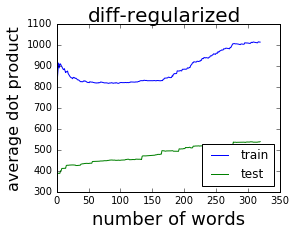

figures/diff_regularized_outer_trigam_dict-N=1000-W=320-170416


In [17]:
W = np.zeros((N,N))
W = reg_train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]

    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + (testpres2*N)
    
    #print (train_pred.shape, test_pred.shape)
    y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
    y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    W = reg_train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,title='diff-regularized', legend='lower right')

fname =  ('figures/diff_regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)